In [116]:
import os
import yaml
import pandas as pd
import psycopg2
from triage.experiments import MultiCoreExperiment, SingleThreadedExperiment
from triage import create_engine
from sqlalchemy.engine.url import URL

from triage.component.postmodeling.modeling_report_functions import *
from triage.component.postmodeling.report_generator import PostmodelingReport

### Connecting to the Database

In [20]:
db_url = URL(
            'postgres',
            host=os.getenv('PGHOST'),
            username=os.getenv('PGUSER'),
            database=os.getenv('PGDATABASE'),
            password=os.getenv('PGPASSWORD'),
            port=5432,
        )

db_engine = create_engine(db_url)

### Creating the sampled down version of the database

In [13]:
# sampled_schema_script = '../triage-demo/create_sampled_schema.sql'

# with open(sampled_schema_script, 'r') as script:
#     with db_engine.begin() as conn:
#         conn.execute(script.read())

# q = "alter schema sampled_new rename to data;"
# with db_engine.begin() as conn:
#     conn.execute(q)

### Data

In [14]:
pd.read_sql('SELECT COUNT(*) FROM data.projects', db_engine)

,count
0,16970


In [11]:
pd.read_sql('SELECT * FROM data.projects LIMIT 5', db_engine)

,projectid_str,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,entity_id
0,f6e80b1f5d7cf197febb4653307ff4b6,e833609fbc39faa96dc1f529c44a3377,0c3fae927a13458d94f01da2c28e23db,040880000869,32.220703,-110.950249,Tucson,AZ,85719,urban,...,moderate poverty,Grades 6-8,35.0,473.58,557.15,50,True,False,2010-09-29,427506
1,dd5862a0cc97890ba12c17b8007d5a42,e29bff7df6220a649f7395a9db28ec34,0c3fae927a13458d94f01da2c28e23db,040880000869,32.220703,-110.950249,Tucson,AZ,85719,urban,...,moderate poverty,Grades 3-5,35.0,145.00,170.59,85,False,False,2010-12-09,406605
2,d1e495a3f67f2ecfb0728400691a048d,e833609fbc39faa96dc1f529c44a3377,0c3fae927a13458d94f01da2c28e23db,040880000869,32.220703,-110.950249,Tucson,AZ,85719,urban,...,moderate poverty,Grades 6-8,35.0,360.76,424.42,100,False,False,2010-12-12,405148
3,daca1f6123b048fbfce7c1f069952f45,e833609fbc39faa96dc1f529c44a3377,0c3fae927a13458d94f01da2c28e23db,040880000869,32.220703,-110.950249,Tucson,AZ,85719,urban,...,moderate poverty,Grades 6-8,35.0,340.34,400.40,100,False,False,2010-12-12,404486
4,7740ea5c8b2018270b25c77b07280fcb,951b11501fd6c5a236f5933ef3142449,3382a7ba6ecff5310c6b2690b00cb87f,470147001837,36.042358,-82.935020,Greeneville,TN,37743,rural,...,high poverty,Grades 3-5,17.0,383.00,467.07,38,False,False,2008-01-28,591492


### Modeling problem Formulation

**Unit of analysis** - Projects

**Cohort** - All the projects that were posted "yesterday"

**Label** - Do the projects reach their funding goal? 

### Configuration File for Triage

In [86]:
config_yaml = """
config_version: 'v8'

model_comment: 'tutorial'

random_seed: 1995

temporal_config:

    # first date our feature data is good
    feature_start_time: '2000-01-01'
    feature_end_time: '2013-06-01'

    # first date our label data is good
    # donorschoose: as far back as we have good donation data
    label_start_time: '2011-09-02'
    label_end_time: '2013-06-01'

    model_update_frequency: '4month'

    # length of time defining a test set
    test_durations: ['3month']
    # defines how far back a training set reaches
    max_training_histories: ['1y']

    # we sample every day, since new projects are posted
    # every day
    training_as_of_date_frequencies: ['1day']
    test_as_of_date_frequencies: ['1day']
    
    # like our project timeout
    training_label_timespans: ['4month']
    test_label_timespans: ['4month']
    

cohort_config:
  query: |
    SELECT distinct(entity_id), date_posted as as_of_date
      FROM data.projects
    WHERE date_posted = '{as_of_date}'::date - interval '1day'

label_config:
  query: |
        WITH donation_totals AS 
            (SELECT projects.entity_id, 
            sum(case when donation_to_project is null then 0 else donation_to_project end) as total_donations, 
            total_asking_price AS total_price
            FROM data.projects 
            LEFT JOIN data.donations ON 
                (donations.entity_id = projects.entity_id
                    and donations.donation_timestamp < (projects.date_posted + interval '{label_timespan}'))
            WHERE projects.date_posted = '{as_of_date}'::date - interval '1day'
            GROUP BY projects.entity_id, projects.total_asking_price)
        SELECT entity_id,
        (total_donations < total_price)::int AS outcome  
        FROM data.projects
        RIGHT JOIN donation_totals using(entity_id)

  name: 'quickstart_label'


feature_aggregations:
  -
    prefix: 'project_features'
    from_obj: 'data.projects'
    knowledge_date_column: 'date_posted'

    aggregates_imputation:
      all:
        type: 'zero'

    categoricals_imputation:
      all:
        type: 'null_category'          

    categoricals:
      -
        column: 'resource_type'
        metrics:
          - 'max' 
        choice_query: 'select distinct resource_type from data.projects'

      - 
        column: 'teacher_prefix'
        metrics:
            - 'max'
        choice_query: 'select distinct teacher_prefix from data.projects'
    
    aggregates:
      -
        quantity: 'total_asking_price'
        metrics:
          - 'sum'
      
    # Since our time-aggregate features are precomputed, feature interval is 
    # irrelvant. We keep 'all' as a default.
    intervals: ['all'] 
    
  - 
    prefix: 'teachr_funding'
    from_obj: |
        (select 
            p1.entity_id, d.donation_timestamp, d.donation_to_project as donation
        from data.projects p1 
        left join data.projects p2 
            on p1.teacher_acctid=p2.teacher_acctid and p1.date_posted > p2.date_posted
        left join data.donations d 
            on p2.entity_id=d.entity_id and d.donation_timestamp < p1.date_posted
        ) as teacher_funding
    knowledge_date_column: 'donation_timestamp'
    
    aggregates_imputation:
      all: 
        type: 'zero_noflag' 

    aggregates:
      - 
        quantity: 'donation'
        metrics:
          - 'sum'
          - 'avg'
    
    intervals: ['all', '1month', '6month']
    
    
  - # precomputed donation history features
    prefix: 'donation_features'
    from_obj: 'data.time_series_features'
    knowledge_date_column: 'date_posted'

    aggregates_imputation:
      all:
        type: 'constant'
        value: 0 # for testing

    aggregates:
      - # proportion of fully funded projects posted within the last year at the same district
        quantity: 'district_funding_rate_1yr'
        metrics:
          - 'max'
      - # average donations per project posted within the last year at the same district
        quantity: 'district_avg_donations_1yr'
        metrics:
          - 'max'

    intervals: ['all']
      
      
grid_config:
    'sklearn.ensemble.RandomForestClassifier':
      n_estimators: [150]
      max_depth: [50]
      min_samples_split: [25]
    
    'sklearn.tree.DecisionTreeClassifier':
      max_depth: [3]
      max_features: [null]
      min_samples_split: [25]
      
    'triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression':
        C: [0.1]
        penalty: ['l1']
    
    'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature':
        rules:
            - [{feature: 'project_features_entity_id_all_total_asking_price_sum', low_value_high_score: False}]


scoring:
    testing_metric_groups:
        -
          metrics: [precision@, recall@]
          thresholds:
              percentiles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 
                  10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                  20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
                  30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
                  40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                  60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                  70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                  80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                  100]
              top_n: []

bias_audit_config:
    from_obj_table: 'data.projects'
    attribute_columns:
        - 'teacher_prefix'
    knowledge_date_column: 'date_posted'
    entity_id_column: 'entity_id'
    ref_groups_method: 'predefined'
    ref_groups:
        'teacher_prefix': 'Mr.'
    thresholds:
        percentiles: [5, 10, 15, 20, 25, 50, 100]
        top_n: [25, 50, 100]
          
individual_importance:
    methods: [] # empty list means don't calculate individual importances
    n_ranks: 1 

"""

config = yaml.safe_load(config_yaml)

In [87]:
project_folder = '/mnt/data/projects/donors_sample'

### Running the models

In [88]:
experiment = SingleThreadedExperiment(
    config=config,
    db_engine=db_engine,
    project_path=project_folder,
    replace=True,
    save_predictions=True
)

2024-03-30 00:56:44 - VERBOSE Matrices and trained models will be saved in /mnt/data/projects/donors_sample
2024-03-30 00:56:44 -  NOTICE Replace flag is set to true. Matrices, models, evaluations and predictions (if they exist) will be replaced
2024-03-30 00:56:44 - VERBOSE Using random seed [1995] for running the experiment
2024-03-30 00:56:47 -  NOTICE scoring.subsets missing in the configuration file or unrecognized. No subsets will be generated


In [89]:
experiment.run()

2024-03-30 00:57:05 - WARNING Section: scoring - No training_metric_groups configured. If training set evaluation metrics are desired, they must be added
2024-03-30 00:57:05 - SUCCESS Experiment validation ran to completion with no errors
2024-03-30 00:57:05 - VERBOSE Computed and stored temporal split definitions
2024-03-30 00:57:06 -    INFO Setting up labels
2024-03-30 00:57:49 - SUCCESS Labels set up in the table labels_quickstart_label_a44d8ee50cde13377f857915a714c704 successfully 
2024-03-30 00:57:49 -    INFO Setting up cohort
2024-03-30 00:57:58 - SUCCESS Cohort set up in the table cohort_default_f3105304d8163f2c4e3cca659ddc6d9e successfully
2024-03-30 00:57:58 -    INFO Creating features tables (before imputation) 
2024-03-30 00:57:58 -    INFO Creating collate aggregations


/home/kasun/.pyenv/versions/3.8.2/envs/donors-3.8.2/lib/python3.8/site-packages/sqlalchemy/sql/base.py:299: SAWarning:

Can't validate argument 'autoload_from'; can't locate any SQLAlchemy dialect named 'autoload'



2024-03-30 00:58:02 - VERBOSE Starting Feature aggregation
2024-03-30 00:58:02 -  NOTICE Imputed feature table project_features_aggregation_imputed looks good, skipping feature building!
2024-03-30 00:58:03 -  NOTICE Imputed feature table teachr_funding_aggregation_imputed looks good, skipping feature building!
2024-03-30 00:58:03 -  NOTICE Imputed feature table donation_features_aggregation_imputed looks good, skipping feature building!
2024-03-30 01:02:04 - SUCCESS Features (before imputation) were stored in the tables "features"."project_features_aggregation","features"."teachr_funding_aggregation","features"."donation_features_aggregation" successfully
2024-03-30 01:02:04 -    INFO Imputing missing values in features
2024-03-30 01:02:04 - VERBOSE Starting Feature imputation
dict_keys(['project_features_entity_id_all_total_asking_price_sum', 'project_features_entity_id_all_resource_type_Other_max', 'project_features_entity_id_all_resource_type_Visitors_max', 'project_features_entity

### Model Selection - Let's see how well the models performed

We use the submodule Audition for this (part of triage)

In [90]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage.component.audition.rules_maker import SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import yaml
from sqlalchemy.engine.url import URL
from triage.util.db import create_engine

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [91]:
pd.read_sql('select run_hash from triage_metadata.triage_runs order by start_time desc limit 1', db_engine)

,run_hash
0,42c8aa1dd9d1130a6285c8d31b3eb8c0


In [92]:
metric = 'precision@'
parameter = '10_pct'
run_hash = '65549749a94ef1d6c858ffd1d21300b9'

In [93]:
best_dist_table = 'audition_best_dist'

In [94]:
pre_aud = PreAudition(
    db_engine,
    baseline_model_types=[
        'sklearn.dummy.DummyClassifier',
        'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature',
        'triage.component.catwalk.baselines.thresholders.SimpleThresholder'
    ]
)

# select model groups by experiment hash id
model_groups = pre_aud.get_model_groups_from_experiment(run_hash)

# Note that this will find train_end_times associated with the model groups defined above
end_times = pre_aud.get_train_end_times(after='1900-01-01')

In [95]:
# Number of non-baseline model groups:
print(len(model_groups['model_groups']))

3


In [96]:
print(len(model_groups['baseline_model_groups']))

1


In [97]:
end_times

[Timestamp('2012-03-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2012-11-01 00:00:00')]

In [98]:
aud = Auditioner(
    db_engine = db_engine,
    model_group_ids = model_groups['model_groups'],
    train_end_times = end_times,
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    distance_table = best_dist_table,
    baseline_model_group_ids = model_groups['baseline_model_groups'] # optional
)

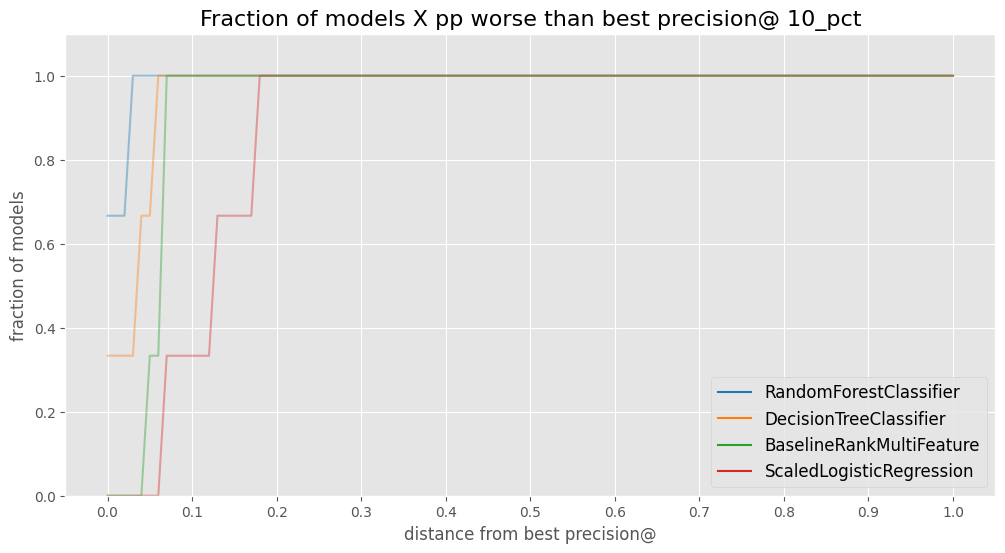

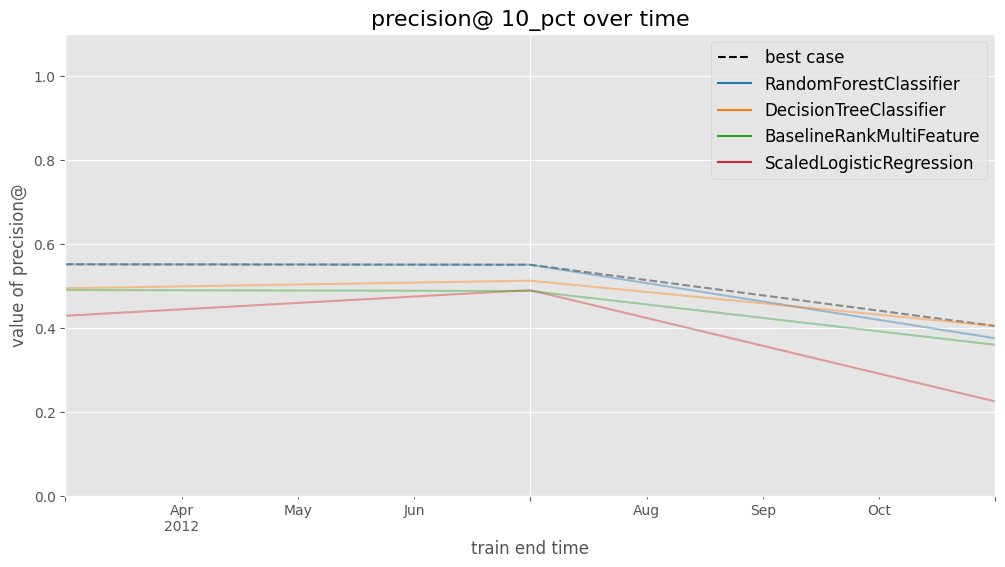

In [99]:
aud.plot_model_groups()

### Best Models


In [100]:
aud.thresholded_model_group_ids

{582, 583, 584}

### Temporal Validation setup

There are 3 train-validation splits


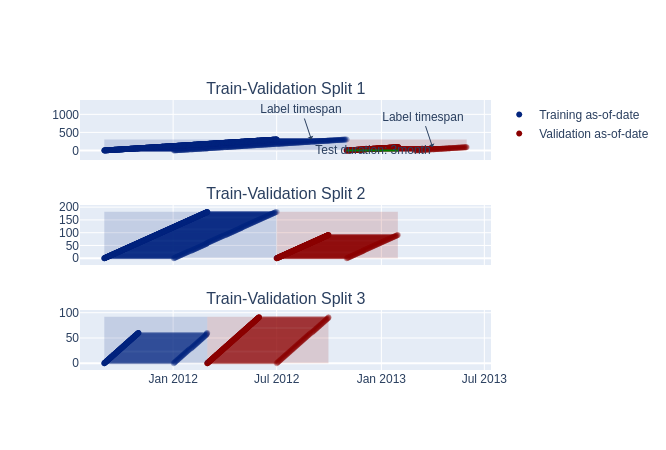

In [101]:

q = f'''
    select 
        config
    from triage_metadata.experiments where experiment_hash = '{run_hash}'
'''

experiment_config = pd.read_sql(q, db_engine).at[0, 'config']


chops = Timechop(**experiment_config['temporal_config'])
splits = len(chops.chop_time())

print(f'There are {splits} train-validation splits')
visualize_chops_plotly(
    chops
)

### What were our cohort sizes?

In [102]:
exp_hash = [run_hash]

In [103]:

get_labels_table_query = """
select distinct labels_table_name from triage_metadata.triage_runs 
where run_hash in ('{}')
"""

labels_table = pd.read_sql(get_labels_table_query.format("','".join(exp_hash)), db_engine)

table_name = list(labels_table['labels_table_name'])[0]

cohort_query = """
select label_name, label_timespan, as_of_date, count(distinct entity_id) as cohort_size, avg(label) as baserate from 
public.{}
group by 1,2,3 order by 1,2,3
"""

result = pd.read_sql(cohort_query.format(table_name), db_engine)
result

,label_name,label_timespan,as_of_date,cohort_size,baserate
0,quickstart_label,120 days,2011-09-02,9,0.1111
1,quickstart_label,120 days,2011-09-03,10,0.3000
2,quickstart_label,120 days,2011-09-04,7,0.1429
3,quickstart_label,120 days,2011-09-05,15,0.3333
4,quickstart_label,120 days,2011-09-06,8,0.5000
5,quickstart_label,120 days,2011-09-07,10,0.3000
6,quickstart_label,120 days,2011-09-08,4,0.2500
7,quickstart_label,120 days,2011-09-09,2,0.0000
8,quickstart_label,120 days,2011-09-10,5,0.6000
9,quickstart_label,120 days,2011-09-11,2,0.0000


### Models we tested

In [104]:

mg_query_all = '''
    select distinct model_group_id, model_type, hyperparameters
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
    where experiment_hash in (select run_hash as experiment_hash from 
triage_metadata.triage_runs  where current_status = 'completed')
order by 2
'''

mg_query_selected_exp = ''' 
    select distinct model_group_id, model_type, hyperparameters
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
    where experiment_hash in ('{}')
order by 2
'''

model_groups = pd.read_sql(mg_query_selected_exp.format("','".join(exp_hash)), db_engine)

model_groups_ids = model_groups.model_group_id.tolist()
model_groups

,model_group_id,model_type,hyperparameters
0,582,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 150, 'min_samples_split': 25}"
1,583,sklearn.tree.DecisionTreeClassifier,"{'max_depth': 3, 'max_features': None, 'min_samples_split': 25}"
2,586,triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature,"{'rules': [{'feature': 'project_features_entity_id_all_total_asking_price_sum', 'low_value_high_score': False}]}"
3,584,triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression,"{'C': 0.1, 'penalty': 'l1'}"


### All the features we created

In [105]:
all_features = list()

for fg in experiment_config['feature_aggregations']:
    
    for agg in fg['aggregates']:
        d = dict()
        d['feature_group'] = fg['prefix']
        if isinstance(agg['quantity'], dict):
            d['feature_name'] = list(agg['quantity'].keys())[0]
            
        else:
            d['feature_name'] = agg['quantity']
    
        d['metrics'] = ', '.join(agg['metrics'])
        d['time_horizons'] = ', '.join(fg['intervals'])
        d['feature_type'] = 'continuous_aggregate'
        
        if agg.get('imputation') is None: 
            imp = fg.get('aggregates_imputation')
        else:
            imp = agg.get('imputation')
        d['imputation'] = json.dumps(imp)
        # d['num_predictors'] = len(agg['metrics']) * len(fg['intervals'])
        all_features.append(d)
        
    for cat in fg.get('categoricals', {}):
        d = dict()
        d['feature_group'] = fg['prefix']
        d['feature_name'] = cat['column']
        d['metrics'] = ', '.join(cat['metrics'])
        d['time_horizons'] = ', '.join(fg['intervals'])
        d['feature_type'] = 'categorical_aggregate'
        
        if agg.get('imputation') is None: 
            imp = fg.get('categoricals_imputation')
        else:
            imp = agg.get('imputation')
        d['imputation'] = json.dumps(imp)
        # d['num_predictors'] = 'number of categories'
        all_features.append(d)
        
all_features = pd.DataFrame(all_features).sort_values('feature_group', ignore_index=True)


In [106]:
all_features

,feature_group,feature_name,metrics,time_horizons,feature_type,imputation
0,donation_features,district_funding_rate_1yr,max,all,continuous_aggregate,"{""all"": {""type"": ""constant"", ""value"": 0}}"
1,donation_features,district_avg_donations_1yr,max,all,continuous_aggregate,"{""all"": {""type"": ""constant"", ""value"": 0}}"
2,project_features,total_asking_price,sum,all,continuous_aggregate,"{""all"": {""type"": ""zero""}}"
3,project_features,resource_type,max,all,categorical_aggregate,"{""all"": {""type"": ""null_category""}}"
4,teachr_funding,donation,"sum, avg","all, 1month, 6month",continuous_aggregate,"{""all"": {""type"": ""zero_noflag""}}"


In [118]:
report = PostmodelingReport(
    # model_groups=best_models.index.tolist(),
    model_groups = [582, 583, 584],
    engine=db_engine,
    experiment_hashes=exp_hash
)

In [119]:
report.print_model_summary()

582 - sklearn.ensemble.RandomForestClassifier with ({'max_depth': 50, 'n_estimators': 150, 'min_samples_split': 25}) 
583 - sklearn.tree.DecisionTreeClassifier with ({'max_depth': 3, 'max_features': None, 'min_samples_split': 25}) 
584 - triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression with ({'C': 0.1, 'penalty': 'l1'}) 


### Precision and Recall Curves

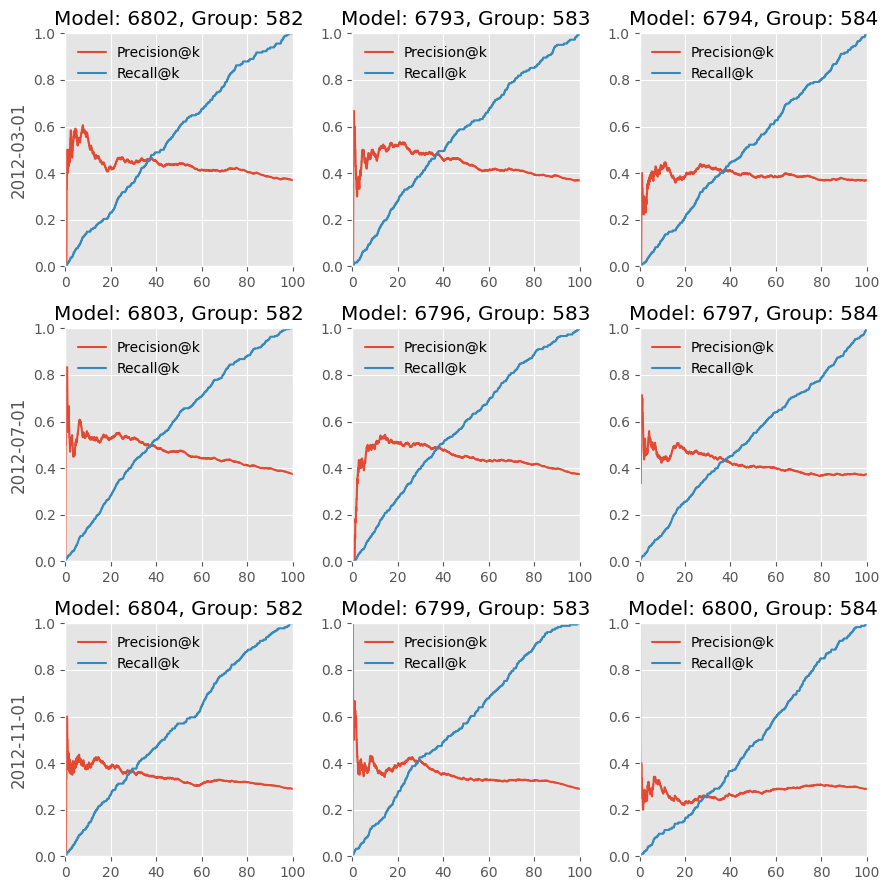

In [120]:
report.plot_prk_curves(
    pct_step_size=0.001
)

### Score Distributions

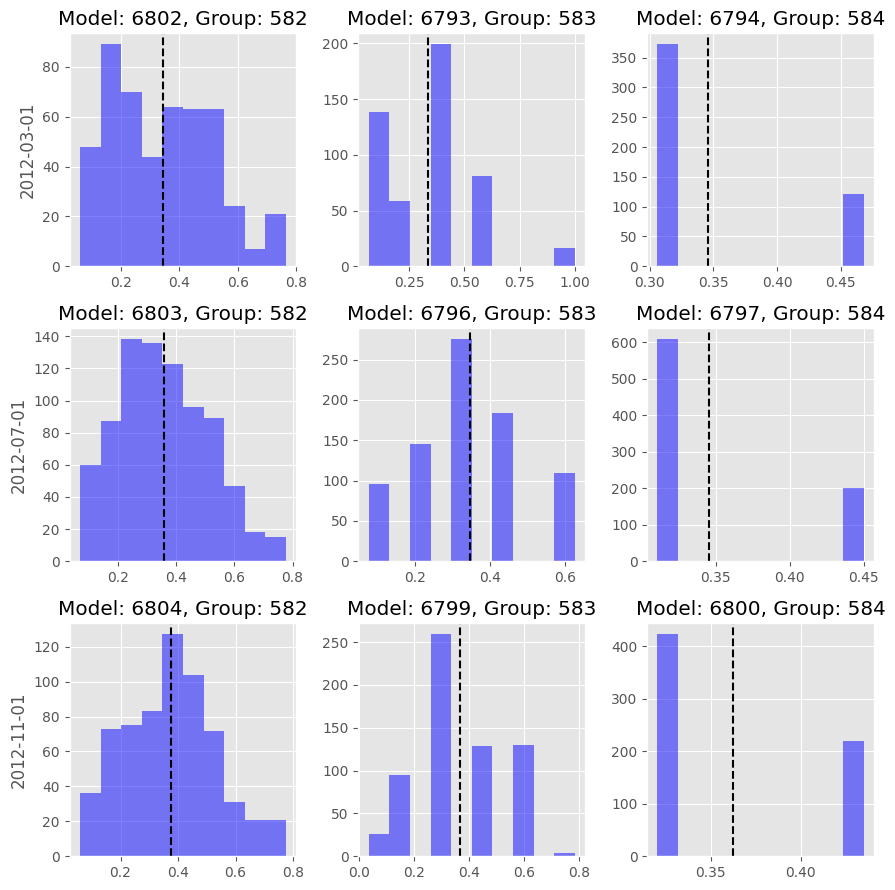

In [122]:
report.plot_score_distributions()

### Feature Importance

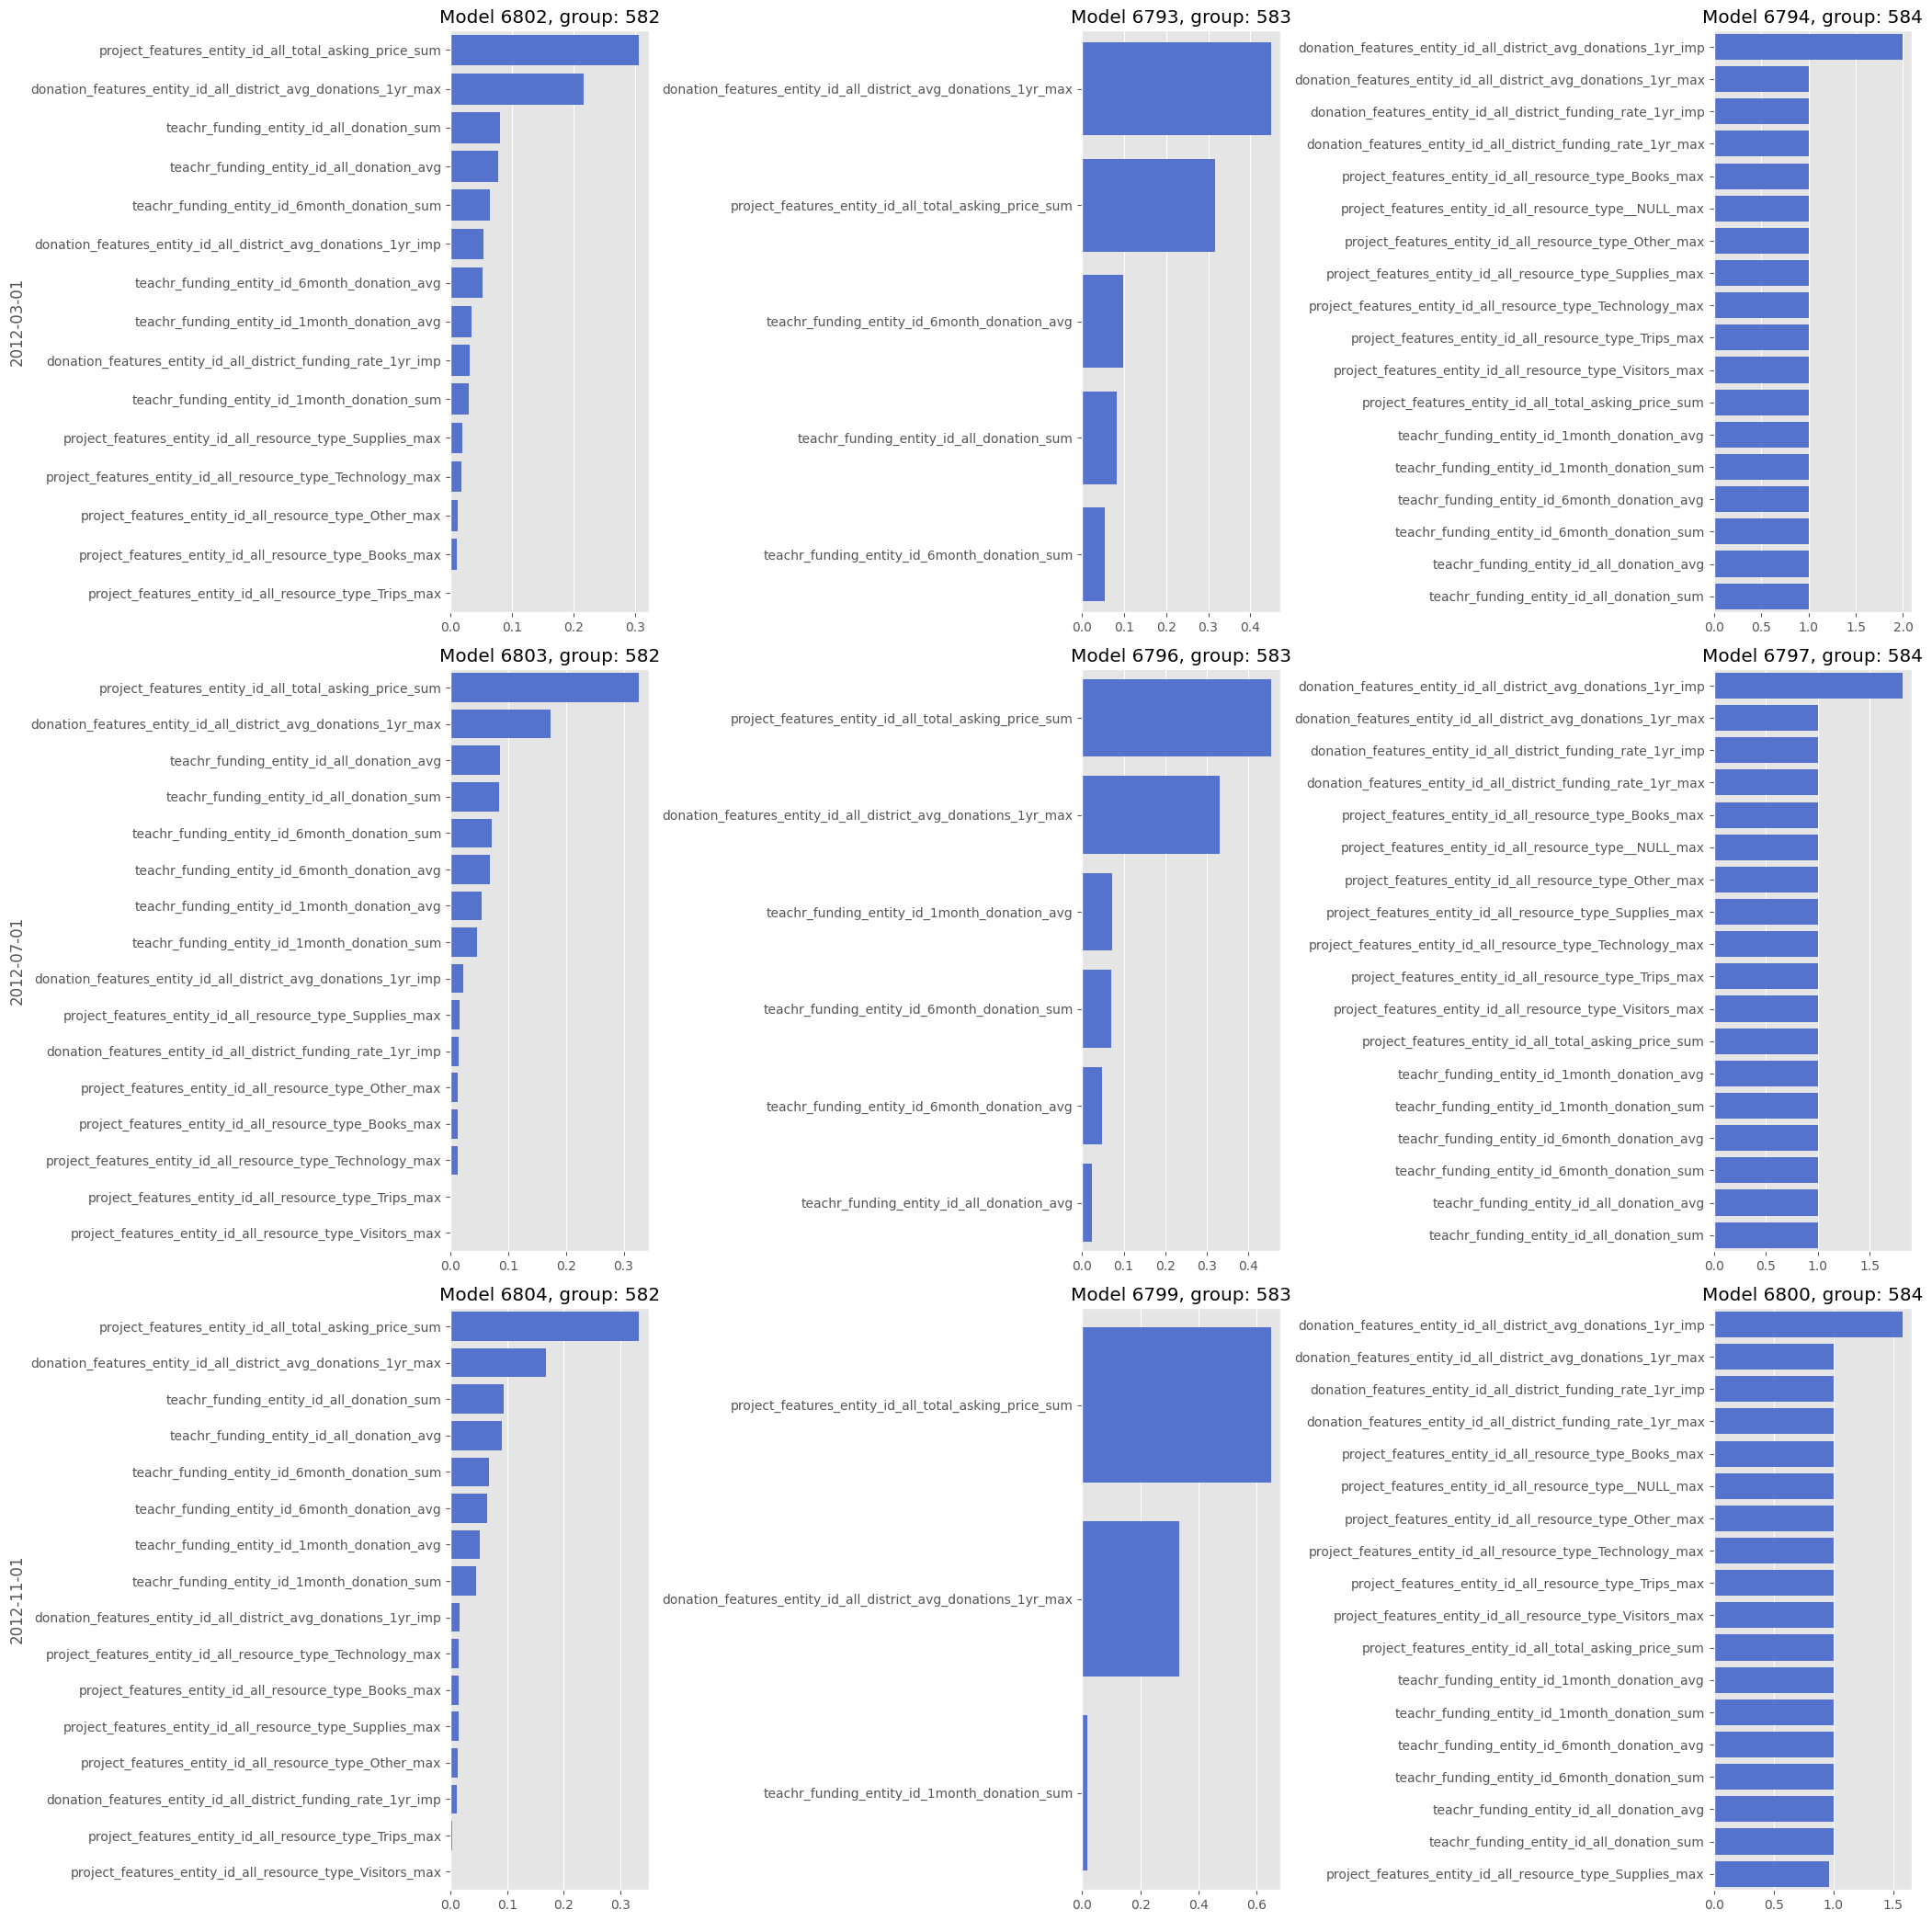

In [123]:
report.plot_feature_importance()


### Feature Group Importance

Above, we saw the individual predictors with the most predictive power. The following plot shows the importance of predictor groups. The groups represent different types of raw data used in creating the predictors, and can be useful gauge the types of information provide the most predictive power to the machine learning models.

582 - sklearn.ensemble.RandomForestClassifier with ({'max_depth': 50, 'n_estimators': 150, 'min_samples_split': 25}) 
583 - sklearn.tree.DecisionTreeClassifier with ({'max_depth': 3, 'max_features': None, 'min_samples_split': 25}) 
584 - triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression with ({'C': 0.1, 'penalty': 'l1'}) 


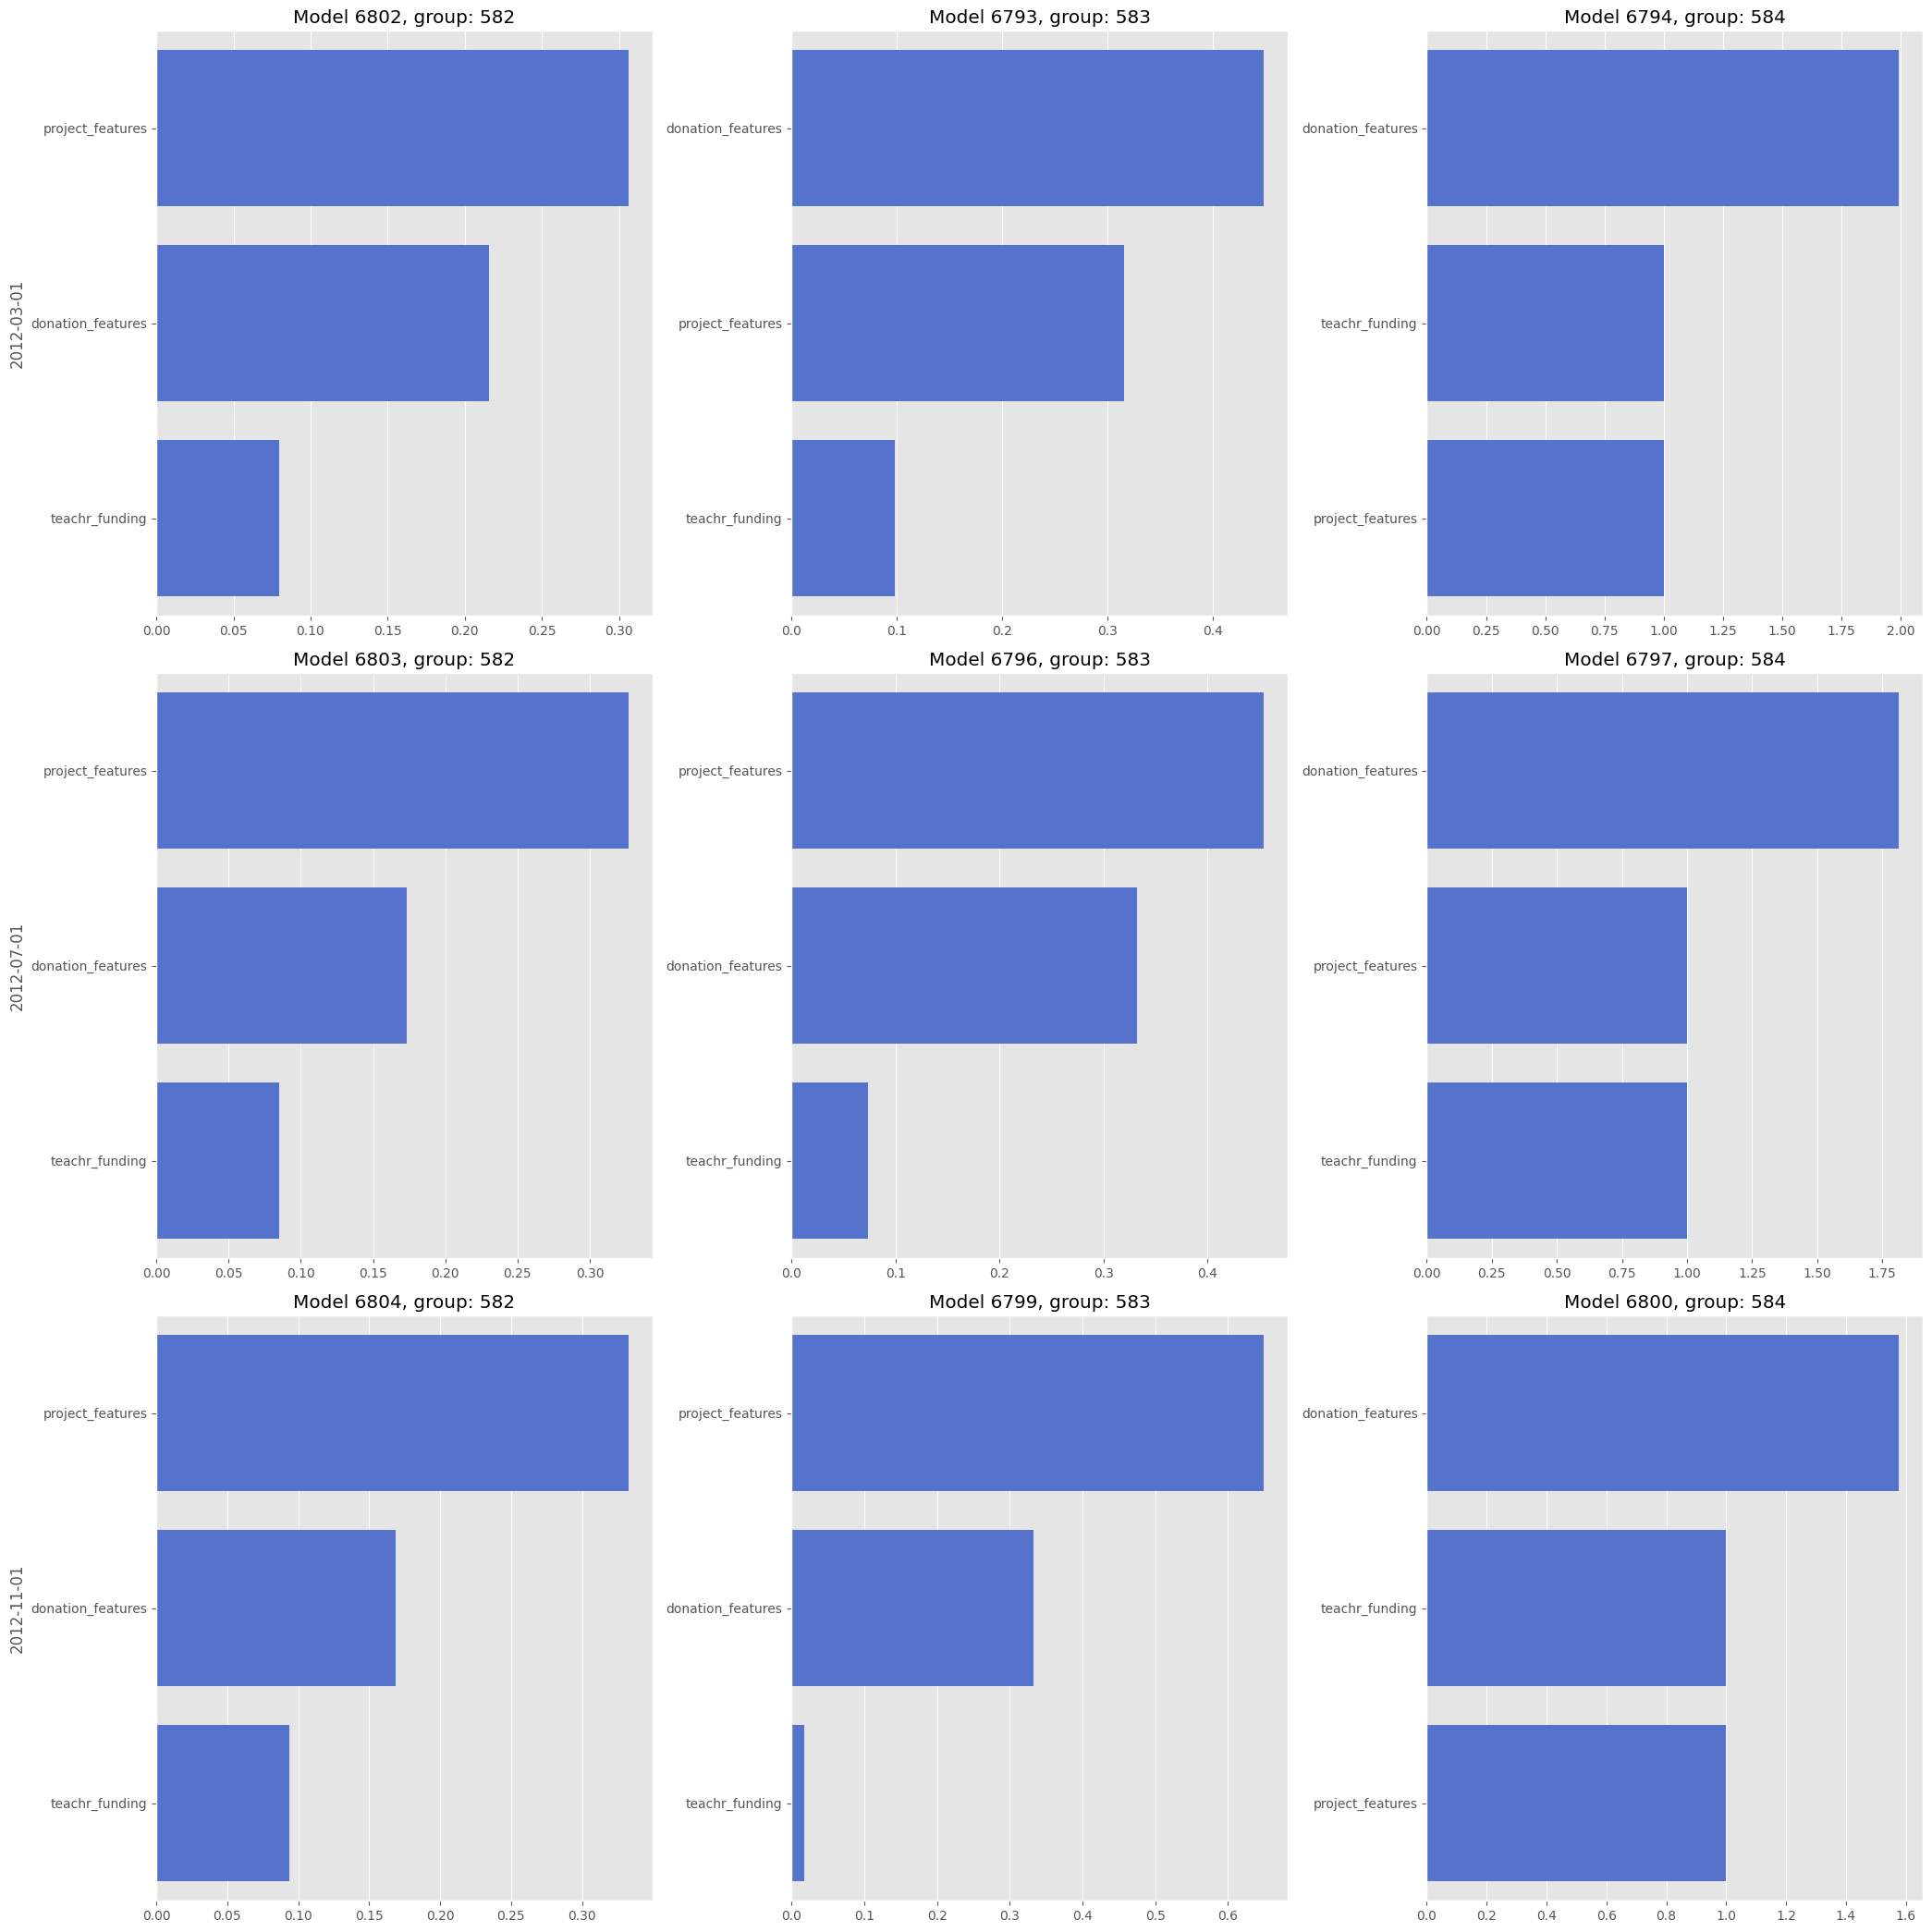

In [124]:

report.print_model_summary()
report.plot_feature_group_importance(n_top_groups=3)

### Crosstabs

In [129]:
model_groups = [582, 583, 584]
logging.info(f'Creating crosstabs for model groups {model_groups}')
report = PostmodelingReport(
    model_groups=model_groups,
    engine=db_engine,
    experiment_hashes=[run_hash]
)

report.calculate_crosstabs_pos_vs_neg(
    project_path=project_folder, 
    thresholds={'rank_pct_no_ties': 0.10},
    table_name='crosstabs',
    replace=False
)

2024-03-30 01:27:11 -    INFO Creating crosstabs for model groups [582, 583, 584]
2024-03-30 01:27:11 -    INFO file in FS
2024-03-30 01:27:11 -    INFO file in FS
2024-03-30 01:27:11 -    INFO file in FS
2024-03-30 01:27:11 -    INFO Crosstabs using threshold: rank_pct_no_ties <= 0.1
2024-03-30 01:27:11 -    INFO mean_predicted_positive
2024-03-30 01:27:11 -    INFO mean_predicted_negative
2024-03-30 01:27:11 -    INFO std_predicted_positive
2024-03-30 01:27:11 -    INFO std_predicted_negative
2024-03-30 01:27:11 -    INFO mean_ratio
2024-03-30 01:27:11 -    INFO support_predicted_positive
2024-03-30 01:27:11 -    INFO support_predicted_negative
2024-03-30 01:27:11 -    INFO support_pct_predicted_positive
2024-03-30 01:27:11 -    INFO support_pct_predicted_negative
2024-03-30 01:27:11 -    INFO Pushing the results to the DB
2024-03-30 01:27:27 -    INFO file in FS
2024-03-30 01:27:27 -    INFO file in FS
2024-03-30 01:27:27 -    INFO file in FS
2024-03-30 01:27:27 -    INFO Crosstabs 

In [131]:
xtabs = report.display_crosstab_pos_vs_neg(
    threshold_type='rank_pct_no_ties',
    threshold=0.10,
    table_name='crosstabs',
    support_threshold=0.1,
    display_n_features=40
)


Model Group: 582, Validation date: 2012-03-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
teachr_funding_entity_id_1month_donation_sum,508.7560,24.5135,20.7541,0.432,0.020
teachr_funding_entity_id_1month_donation_avg,121.9041,8.1712,14.9188,0.432,0.020
teachr_funding_entity_id_6month_donation_sum,2160.2993,176.6369,12.2302,0.633,0.163
donation_features_entity_id_all_district_avg_donations_1yr_max,265.1170,30.4316,8.7119,0.822,0.143
teachr_funding_entity_id_all_donation_sum,3308.9143,399.9896,8.2725,0.734,0.306
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.1441,0.7959,5.5217,0.144,0.796
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.1779,0.8571,4.8174,0.178,0.857
project_features_entity_id_all_resource_type_Supplies_max,0.3761,0.0816,4.6075,0.376,0.082
teachr_funding_entity_id_6month_donation_avg,130.9853,60.5963,2.1616,0.633,0.163



Model Group: 582, Validation date: 2012-07-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
teachr_funding_entity_id_all_donation_sum,2977.1406,334.2213,8.9077,0.619,0.338
teachr_funding_entity_id_6month_donation_sum,599.9188,76.9800,7.7932,0.394,0.150
donation_features_entity_id_all_district_avg_donations_1yr_max,292.1135,78.3826,3.7268,0.789,0.412
project_features_entity_id_all_resource_type_Supplies_max,0.3896,0.1125,3.4629,0.390,0.112
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.2112,0.5875,2.7811,0.211,0.588
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.1934,0.4500,2.3266,0.193,0.450
teachr_funding_entity_id_1month_donation_sum,82.6828,36.1145,2.2895,0.206,0.075
project_features_entity_id_all_resource_type_Technology_max,0.2593,0.5125,1.9768,0.259,0.512
project_features_entity_id_all_resource_type_Other_max,0.1385,0.0750,1.8473,0.139,0.075



Model Group: 582, Validation date: 2012-11-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
teachr_funding_entity_id_all_donation_sum,5339.2520,165.0566,32.3480,0.696,0.297
teachr_funding_entity_id_6month_donation_sum,1306.1449,44.4553,29.3811,0.580,0.094
teachr_funding_entity_id_1month_donation_sum,400.9879,15.2231,26.3407,0.390,0.031
teachr_funding_entity_id_1month_donation_avg,57.7349,3.4480,16.7444,0.390,0.031
donation_features_entity_id_all_district_avg_donations_1yr_max,282.4275,31.7587,8.8929,0.710,0.188
teachr_funding_entity_id_6month_donation_avg,79.4572,10.5006,7.5669,0.580,0.094
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.2902,0.8125,2.8002,0.290,0.812
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.2832,0.6875,2.4272,0.283,0.688
teachr_funding_entity_id_all_donation_avg,84.7824,37.8805,2.2382,0.696,0.297



Model Group: 583, Validation date: 2012-03-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
donation_features_entity_id_all_district_avg_donations_1yr_max,263.3900,46.0811,5.7158,0.791,0.429
teachr_funding_entity_id_6month_donation_sum,2137.7830,380.6614,5.6160,0.608,0.388
teachr_funding_entity_id_1month_donation_avg,119.7322,27.8512,4.2990,0.405,0.265
teachr_funding_entity_id_all_donation_sum,3256.8621,871.6476,3.7364,0.700,0.612
teachr_funding_entity_id_1month_donation_sum,496.2934,137.4402,3.6110,0.405,0.265
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.1712,0.5510,3.2191,0.171,0.551
project_features_entity_id_all_resource_type_Other_max,0.0653,0.1837,2.8121,0.065,0.184
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.2095,0.5714,2.7281,0.209,0.571
teachr_funding_entity_id_6month_donation_avg,131.5815,55.1937,2.3840,0.608,0.388



Model Group: 583, Validation date: 2012-07-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
teachr_funding_entity_id_6month_donation_sum,598.5649,89.3167,6.7016,0.379,0.288
teachr_funding_entity_id_all_donation_sum,2921.1870,844.0999,3.4607,0.606,0.450
project_features_entity_id_all_resource_type_Other_max,0.1399,0.0625,2.2387,0.140,0.062
donation_features_entity_id_all_district_avg_donations_1yr_max,286.2156,132.1269,2.1662,0.770,0.588
teachr_funding_entity_id_1month_donation_sum,82.2222,40.3124,2.0396,0.200,0.125
teachr_funding_entity_id_all_donation_avg,77.2845,40.7451,1.8968,0.606,0.450
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.2016,0.3750,1.8597,0.202,0.375
project_features_entity_id_all_resource_type_Technology_max,0.2634,0.4750,1.8035,0.263,0.475
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.2305,0.4125,1.7900,0.230,0.412



Model Group: 583, Validation date: 2012-11-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
teachr_funding_entity_id_all_donation_sum,5195.5874,1464.7729,3.5470,0.668,0.547
donation_features_entity_id_all_district_avg_donations_1yr_max,276.8557,82.1668,3.3694,0.691,0.359
project_features_entity_id_all_resource_type_Books_max,0.1952,0.0781,2.4981,0.195,0.078
project_features_entity_id_all_resource_type_Supplies_max,0.3178,0.1406,2.2598,0.318,0.141
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.2884,0.6406,2.2211,0.288,0.641
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.3092,0.6406,2.0722,0.309,0.641
project_features_entity_id_all_total_asking_price_sum,468.7138,932.3169,1.9891,1.000,1.000
teachr_funding_entity_id_6month_donation_sum,1241.2365,631.6741,1.9650,0.542,0.438
teachr_funding_entity_id_1month_donation_avg,47.8297,93.0598,1.9457,0.359,0.312



Model Group: 584, Validation date: 2012-03-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
donation_features_entity_id_all_district_avg_donations_1yr_max,268.4755,0.0000,inf,0.838,0.000
teachr_funding_entity_id_6month_donation_sum,2160.9443,170.7914,12.6525,0.624,0.245
teachr_funding_entity_id_all_donation_sum,3320.9387,291.0347,11.4108,0.727,0.367
teachr_funding_entity_id_1month_donation_sum,502.9812,76.8398,6.5458,0.421,0.122
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.1622,1.0000,6.1667,0.162,1.000
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.1396,0.8367,5.9921,0.140,0.837
teachr_funding_entity_id_1month_donation_avg,120.5464,20.4736,5.8879,0.421,0.122
teachr_funding_entity_id_6month_donation_avg,131.8406,52.8459,2.4948,0.624,0.245
teachr_funding_entity_id_all_donation_avg,127.6857,53.7856,2.3740,0.727,0.367



Model Group: 584, Validation date: 2012-07-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
donation_features_entity_id_all_district_avg_donations_1yr_max,300.7151,0.0000,inf,0.834,0.000
teachr_funding_entity_id_all_donation_sum,2999.0117,134.9224,22.2277,0.632,0.212
teachr_funding_entity_id_6month_donation_sum,599.6676,79.2688,7.5650,0.398,0.112
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.1454,0.8875,6.1037,0.145,0.888
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.1660,1.0000,6.0248,0.166,1.000
teachr_funding_entity_id_all_donation_avg,79.7910,17.9049,4.4564,0.632,0.212
teachr_funding_entity_id_6month_donation_avg,53.6467,12.6019,4.2570,0.398,0.112
teachr_funding_entity_id_1month_donation_avg,26.1927,9.8359,2.6630,0.203,0.100
project_features_entity_id_all_resource_type_Technology_max,0.3004,0.1375,2.1848,0.300,0.138



Model Group: 584, Validation date: 2012-11-01


,(-)mean,(+)mean,ratio,(-)supp,(+)supp
feature_name,,,,,
donation_features_entity_id_all_district_avg_donations_1yr_max,285.9380,0.0000,inf,0.731,0.000
project_features_entity_id_all_resource_type_Supplies_max,0.3333,0.0000,inf,0.333,0.000
teachr_funding_entity_id_all_donation_sum,5293.9307,575.0744,9.2056,0.675,0.484
donation_features_entity_id_all_district_funding_rate_1yr_imp,0.2539,0.9531,3.7541,0.254,0.953
donation_features_entity_id_all_district_avg_donations_1yr_imp,0.2694,1.0000,3.7115,0.269,1.000
project_features_entity_id_all_resource_type_Other_max,0.0674,0.1875,2.7837,0.067,0.188
teachr_funding_entity_id_6month_donation_sum,1260.9579,453.2562,2.7820,0.549,0.375
project_features_entity_id_all_resource_type_Technology_max,0.4076,0.6406,1.5717,0.408,0.641
teachr_funding_entity_id_1month_donation_avg,49.9819,73.5883,1.4723,0.363,0.281


### How similar are the models in-terms of their predictions?

2024-03-30 01:28:42 -    INFO Performing 3 comparisons
2024-03-30 01:28:42 -    INFO Comparing 582 and 583
2024-03-30 01:28:42 -    INFO Comparing 582 and 584
2024-03-30 01:28:42 -    INFO Comparing 583 and 584


/mnt/data/users/kasun/triage/src/triage/component/postmodeling/report_generator.py:585: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



2024-03-30 01:28:42 -    INFO Performing 3 comparisons
2024-03-30 01:28:42 -    INFO Comparing 582 and 583
2024-03-30 01:28:42 -    INFO Comparing 582 and 584
2024-03-30 01:28:42 -    INFO Comparing 583 and 584
2024-03-30 01:28:42 -    INFO Performing 3 comparisons
2024-03-30 01:28:42 -    INFO Comparing 582 and 583
2024-03-30 01:28:42 -    INFO Comparing 582 and 584
2024-03-30 01:28:42 -    INFO Comparing 583 and 584


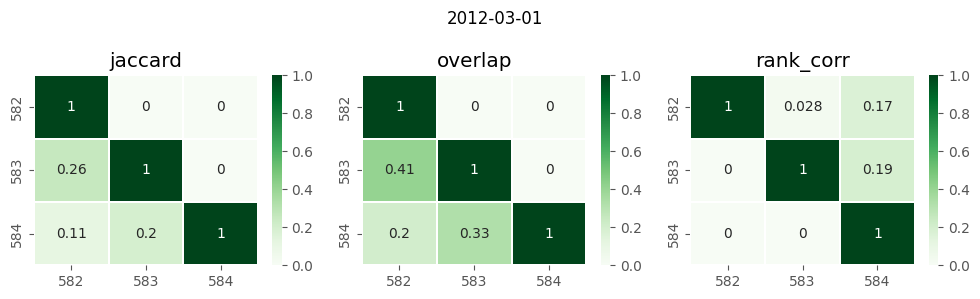

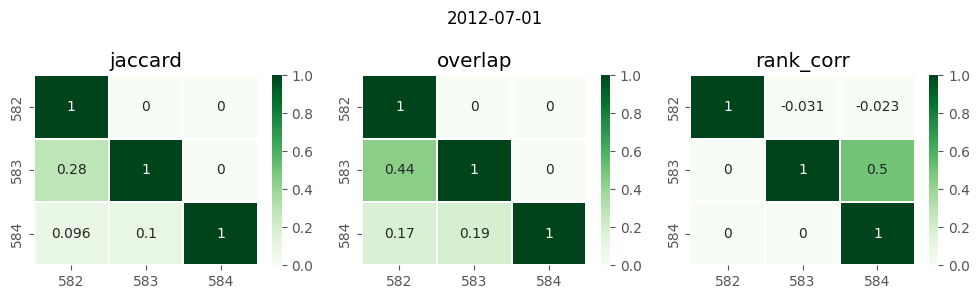

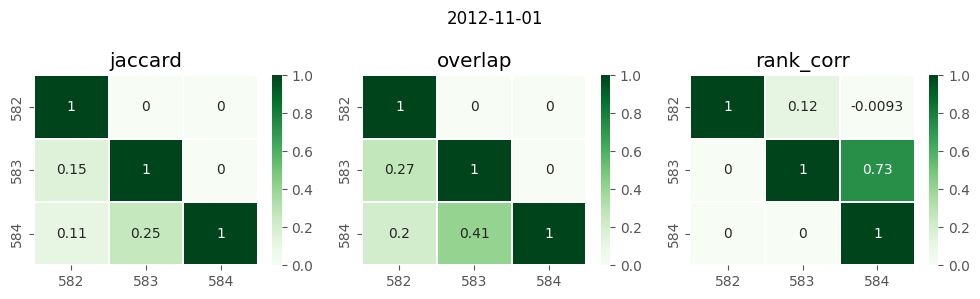

In [132]:
report.pairwise_top_k_list_comparison(
    threshold_type='rank_pct_no_ties',
    threshold=0.10
)